In [1]:
from os import path
%matplotlib inline
from pyprojroot import here
workspace_path = '/Users/seyongpark/Projects/gravitational-lensing'
%cd $workspace_path
print(f"Working Directory has been set to `{workspace_path}`")

import autolens as al
import autolens.plot as aplt
import matplotlib.pylab as plt
import numpy as np
from scipy.interpolate import griddata
from astropy.cosmology import FlatLambdaCDM

/Users/seyongpark/Projects/gravitational-lensing
Working Directory has been set to `/Users/seyongpark/Projects/gravitational-lensing`


## Scale Deflection Angles

In [2]:
# compute scaling ratio for deflection angles
cosmo = FlatLambdaCDM(H0=70, Om0=0.3)

D_ds = cosmo.angular_diameter_distance_z1z2(0.566,6.2) # distance from source to lens
D_s = cosmo.angular_diameter_distance_z1z2(0,6.2) # distance to source
ratio = D_ds/D_s

print("D_ds: {:.2f} D_s: {:.2f}  Scale Factor: {:.4f}".format(D_ds,D_s,ratio))

D_ds: 865.12 Mpc D_s: 1156.85 Mpc  Scale Factor: 0.7478


In [3]:
# paths for deflection data
x_path = path.join("glafic-model","hlsp_relics_model_model_whl0137-08_glafic_v1_x-arcsec-deflect.fits")
y_path = path.join("glafic-model","hlsp_relics_model_model_whl0137-08_glafic_v1_y-arcsec-deflect.fits")

scale = 0.1 # computed from comparing pixel and arcsec files

# read in deflection data
deflections_y = al.Array2D.from_fits(
    file_path=y_path,
    pixel_scales=scale,
)
deflections_x = al.Array2D.from_fits(
    file_path=x_path,
    pixel_scales=scale,
)

# scale deflection angles to account for redshift
deflections_y = al.Array2D.no_mask(ratio*deflections_y.native, 
                                   pixel_scales = scale)
deflections_x = al.Array2D.no_mask(ratio*deflections_x.native, 
                                   pixel_scales = scale)

# construct mass profile using deflections
deflections_plane_grid_2d = al.Grid2D.uniform(
    shape_native=deflections_y.shape_native,
    pixel_scales=scale,  # The pixel-scale describes the conversion from pixel units to arc-seconds
)
input_deflections = al.mp.InputDeflections(
    deflections_y=deflections_y,
    deflections_x=deflections_x,
    image_plane_grid=deflections_plane_grid_2d
)

## Perform Ray Tracing

In [4]:
detector_arcsec_per_pxl = 0.005
reco_image_fov = 20  # arcsec on one side
num_pix = int(reco_image_fov / detector_arcsec_per_pxl)

In [9]:
# define image plane
image_plane_grid_2d = al.Grid2D.uniform(
    shape_native=(num_pix, num_pix),
    pixel_scales=detector_arcsec_per_pxl,
#    origin=(-29.2,25)
    origin=(-30,20)
)
# define lens, source and tracer
lens_galaxy = al.Galaxy(redshift=0.566, mass=input_deflections)
source_galaxy = al.Galaxy(redshift=6.2)
tracer = al.Tracer.from_galaxies(galaxies=[lens_galaxy, source_galaxy],cosmology=al.cosmo.Planck15())

# trace image plane to source plane
traced_image_plane_grid_2d = tracer.traced_grid_2d_list_from(grid=image_plane_grid_2d)

# save traced plane to file
np.save("image_plane.npy",traced_image_plane_grid_2d[0].native)
np.save("source_plane.npy",traced_image_plane_grid_2d[1].native)

Text(0, 0.5, 'y (arcsec)')

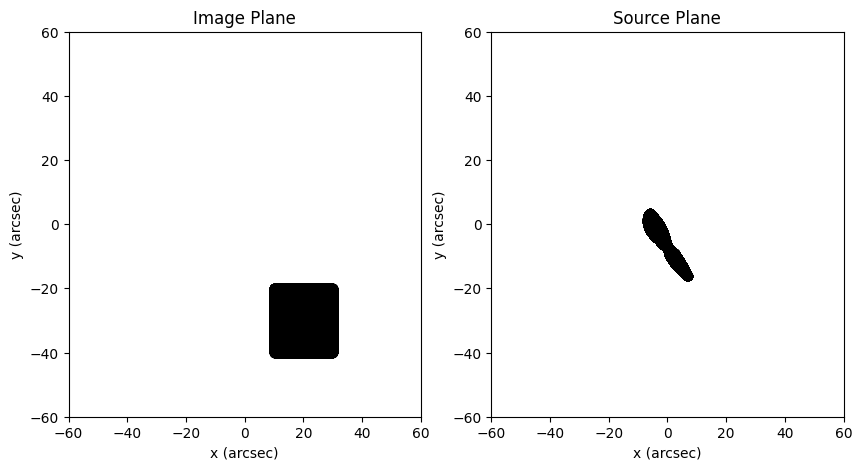

In [10]:
# perform ray tracing from image plane
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.title("Image Plane")
plt.scatter(traced_image_plane_grid_2d[0][:,1],traced_image_plane_grid_2d[0][:,0],color="black",alpha=0.01)
plt.xlim([-60,60])
plt.ylim([-60,60])
plt.xlabel("x (arcsec)")
plt.ylabel("y (arcsec)")

plt.subplot(1,2,2)
plt.scatter(traced_image_plane_grid_2d[-1][:,1],traced_image_plane_grid_2d[-1][:,0],color="black",alpha=0.01)
plt.title("Source Plane")
plt.xlim([-60,60])
plt.ylim([-60,60])
plt.xlabel("x (arcsec)")
plt.ylabel("y (arcsec)")

Text(0, 0.5, 'y (arcsec)')

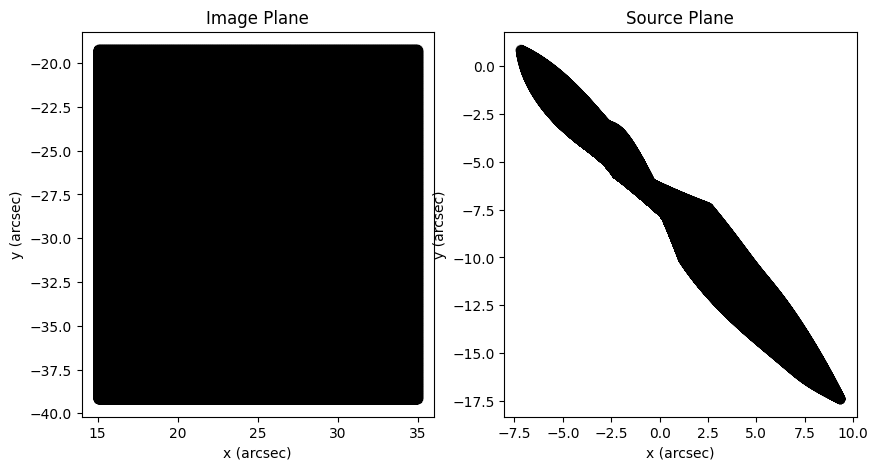

In [8]:
# perform ray tracing from image plane
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.title("Image Plane")
plt.scatter(traced_image_plane_grid_2d[0][:,1],traced_image_plane_grid_2d[0][:,0],color="black",alpha=0.01)
plt.xlabel("x (arcsec)")
plt.ylabel("y (arcsec)")

plt.subplot(1,2,2)
plt.scatter(traced_image_plane_grid_2d[-1][:,1],traced_image_plane_grid_2d[-1][:,0],color="black",alpha=0.01)
plt.title("Source Plane")
plt.xlabel("x (arcsec)")
plt.ylabel("y (arcsec)")